<a href="https://colab.research.google.com/github/NullCipherr/Titanic_Survival_Prediction/blob/main/Titanic_Survival_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 0. Importando as bibliotecas

In [ ]:
# Importação das bibliotecas necessárias
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# 1. Seleção do Dataset

Objetivo: Carregar um dataset de exemplo (neste caso, o Titanic) para aplicar técnicas de aprendizado de máquina.

Resultado: Um DataFrame df contendo os dados do Titanic.

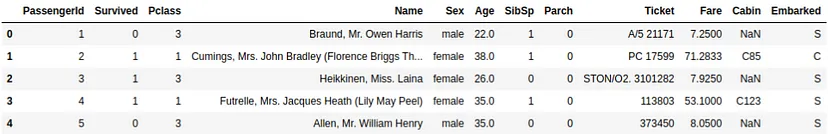

In [ ]:
# 1. Seleção do Dataset
url = "https://raw.githubusercontent.com/datasciencedojo/datasets/master/titanic.csv"
df = pd.read_csv(url)

# 2. Análise Estátistica Descritiva

Objetivo: Explorar e entender a distribuição dos dados, identificar correlações entre variáveis, e visualizar possíveis outliers.

Resultado:Estatísticas descritivas dos atributos (média, mediana, etc.).
Histogramas, boxplots e uma matriz de correlação que ajudam a visualizar as distribuições e relações entre as variáveis.
Esses gráficos ajudam a compreender a estrutura dos dados e identificar pontos problemáticos ou características importantes para o modelo.

       PassengerId    Survived      Pclass         Age       SibSp  \
count   891.000000  891.000000  891.000000  891.000000  891.000000   
mean    446.000000    0.383838    2.308642   29.361582    0.523008   
std     257.353842    0.486592    0.836071   13.019697    1.102743   
min       1.000000    0.000000    1.000000    0.420000    0.000000   
25%     223.500000    0.000000    2.000000   22.000000    0.000000   
50%     446.000000    0.000000    3.000000   28.000000    0.000000   
75%     668.500000    1.000000    3.000000   35.000000    1.000000   
max     891.000000    1.000000    3.000000   80.000000    8.000000   

            Parch        Fare  
count  891.000000  891.000000  
mean     0.381594   32.204208  
std      0.806057   49.693429  
min      0.000000    0.000000  
25%      0.000000    7.910400  
50%      0.000000   14.454200  
75%      0.000000   31.000000  
max      6.000000  512.329200  


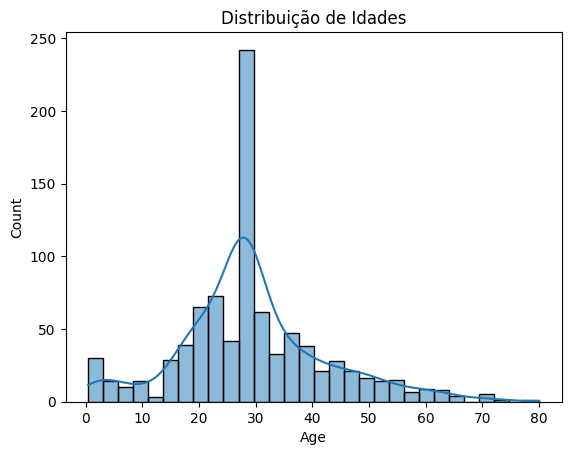

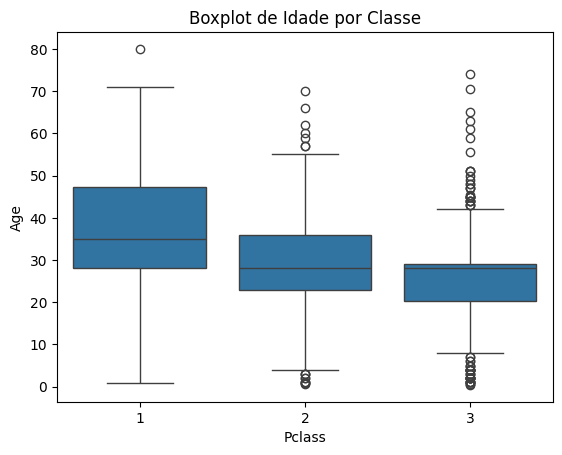

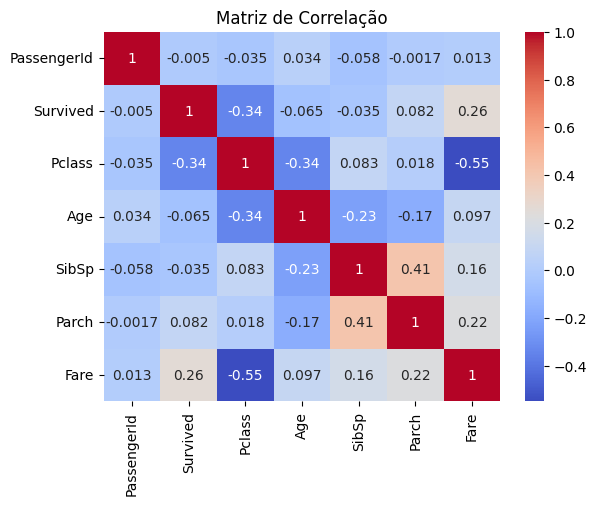

In [ ]:
print(df.describe())

sns.histplot(df['Age'].dropna(), kde=True)
plt.title('Distribuição de Idades')
plt.show()

sns.boxplot(x='Pclass', y='Age', data=df)
plt.title('Boxplot de Idade por Classe')
plt.show()

# Filtrar apenas colunas numéricas para a correlação
numeric_columns = df.select_dtypes(include=[np.number])

sns.heatmap(numeric_columns.corr(), annot=True, cmap="coolwarm")
plt.title('Matriz de Correlação')
plt.show()

# 3. Pré-processamento de Dados

In [ ]:
# Tratamento de valores ausentes
df['Age'].fillna(df['Age'].median(), inplace=True)
df['Embarked'].fillna(df['Embarked'].mode()[0], inplace=True)
df.drop(columns=['Cabin', 'Name', 'Ticket'], inplace=True)

# Codificação de variáveis categóricas
df = pd.get_dummies(df, columns=['Sex', 'Embarked'], drop_first=True)

# Separação em X (features) e y (target)
X = df.drop(columns=['Survived'])
y = df['Survived']

# Divisão em treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 4. Cross-Validation

In [ ]:
k_folds = 5

# 5. Implementação das Técnicas de AM

In [ ]:
# 1ª Técnica: Árvore de Decisão
dt = DecisionTreeClassifier(random_state=42)
dt_scores = cross_val_score(dt, X_train, y_train, cv=k_folds)
print(f"Decision Tree Cross-Validation Accuracy: {np.mean(dt_scores)}")

# 2ª Técnica: Random Forest
rf = RandomForestClassifier(random_state=42)
rf_scores = cross_val_score(rf, X_train, y_train, cv=k_folds)
print(f"Random Forest Cross-Validation Accuracy: {np.mean(rf_scores)}")

Decision Tree Cross-Validation Accuracy: 0.7275780557470698
Random Forest Cross-Validation Accuracy: 0.8047473653107456


# 6. Parametrização com Grid Search

In [ ]:
# Grid Search para Árvore de Decisão
param_grid_dt = {
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

grid_search_dt = GridSearchCV(dt, param_grid_dt, cv=k_folds, scoring='accuracy', n_jobs=-1)
grid_search_dt.fit(X_train, y_train)
best_dt = grid_search_dt.best_estimator_
print(f"Best parameters for Decision Tree: {grid_search_dt.best_params_}")

# Grid Search para Random Forest
param_grid_rf = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

grid_search_rf = GridSearchCV(rf, param_grid_rf, cv=k_folds, scoring='accuracy', n_jobs=-1)
grid_search_rf.fit(X_train, y_train)
best_rf = grid_search_rf.best_estimator_
print(f"Best parameters for Random Forest: {grid_search_rf.best_params_}")

Best parameters for Decision Tree: {'max_depth': 10, 'min_samples_leaf': 4, 'min_samples_split': 2}
Best parameters for Random Forest: {'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 300}


# 7. Avaliação dos Modelos

In [ ]:
# Avaliação com os melhores modelos encontrados
y_pred_dt = best_dt.predict(X_test)
y_pred_rf = best_rf.predict(X_test)

print("Decision Tree Performance:")
print(f"Accuracy: {accuracy_score(y_test, y_pred_dt)}")
print(classification_report(y_test, y_pred_dt))

print("Random Forest Performance:")
print(f"Accuracy: {accuracy_score(y_test, y_pred_rf)}")
print(classification_report(y_test, y_pred_rf))

Decision Tree Performance:
Accuracy: 0.770949720670391
              precision    recall  f1-score   support

           0       0.78      0.86      0.81       105
           1       0.76      0.65      0.70        74

    accuracy                           0.77       179
   macro avg       0.77      0.75      0.76       179
weighted avg       0.77      0.77      0.77       179

Random Forest Performance:
Accuracy: 0.8212290502793296
              precision    recall  f1-score   support

           0       0.83      0.88      0.85       105
           1       0.81      0.74      0.77        74

    accuracy                           0.82       179
   macro avg       0.82      0.81      0.81       179
weighted avg       0.82      0.82      0.82       179



# **Descrição do Código**
Seleção do Dataset: O dataset Titanic é carregado diretamente de uma URL pública no GitHub.

Análise Estatística Descritiva: Estatísticas descritivas, histogramas, boxplots, e uma matriz de correlação são gerados para explorar os dados.

Pré-processamento de Dados: Tratamento de valores ausentes e codificação de variáveis categóricas é realizado.

Cross-Validation: Cross-validation com k-folds é aplicado para validar a robustez dos modelos.

Implementação das Técnicas de AM: Uma Árvore de Decisão e um Random Forest são treinados e avaliados usando cross-validation.

Parametrização com Grid Search: Grid Search é usado para otimizar os hiperparâmetros de ambos os modelos.

Avaliação dos Modelos: Os modelos otimizados são avaliados no conjunto de teste.

Melhoria dos Resultados: A equipe pode explorar técnicas adicionais para tentar melhorar os resultados.


║         ANÁLISE DE DADOS DO TITANIC         ║
║ 1. Realizar Análise Descritiva              ║
║ 2. Pré-processar os Dados                   ║
║ 3. Buscar Passageiros                       ║
║ 4. Treinar Modelos                          ║
║ 5. Ajustar Hiperparâmetros                  ║
║ 6. Avaliar Modelos                          ║
║ 7. Sair                                     ║
Escolha uma opção (1-7): 2

--------------------------------------------------
Pré-processando os Dados...
--------------------------------------------------
✔ Dados pré-processados com sucesso!

Pressione Enter para continuar...

║         ANÁLISE DE DADOS DO TITANIC         ║
║ 1. Realizar Análise Descritiva              ║
║ 2. Pré-processar os Dados                   ║
║ 3. Buscar Passageiros                       ║
║ 4. Treinar Modelos                          ║
║ 5. Ajustar Hiperparâmetros                  ║
║ 6. Avaliar Modelos                          ║
║ 7. Sair                                     ║


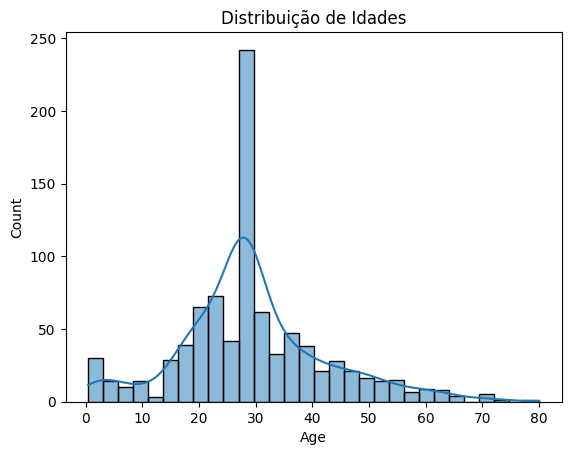

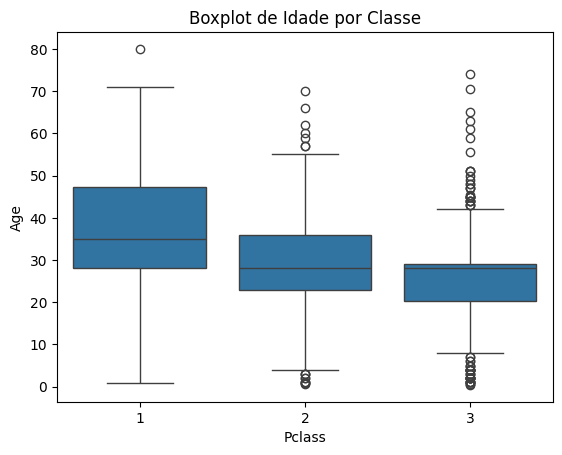

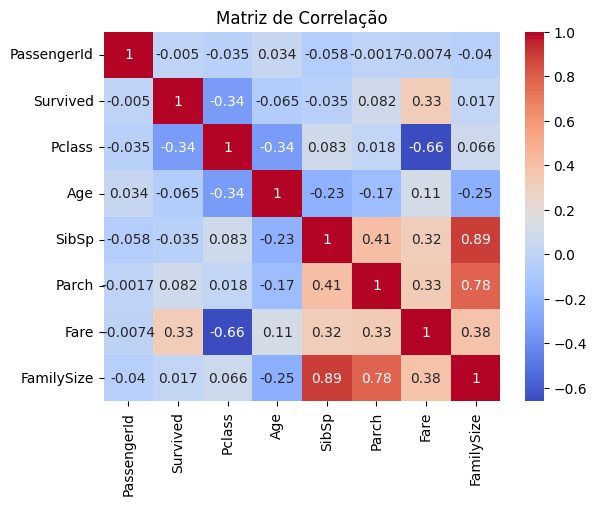

ValueError: Could not interpret value `Sex` for `hue`. An entry with this name does not appear in `data`.

In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RepeatedStratifiedKFold, ParameterGrid
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline


class DataPreparation:
    def __init__(self, url):
        self.df = pd.read_csv(url)

    def descriptive_analysis(self):
        print(self.df.describe())
        sns.histplot(self.df['Age'].dropna(), kde=True)
        plt.title('Distribuição de Idades')
        plt.show()

        sns.boxplot(x='Pclass', y='Age', data=self.df)
        plt.title('Boxplot de Idade por Classe')
        plt.show()

        numeric_columns = self.df.select_dtypes(include=[np.number])
        sns.heatmap(numeric_columns.corr(), annot=True, cmap="coolwarm")
        plt.title('Matriz de Correlação')
        plt.show()

        self.plot_survival_by_gender()
        self.plot_survival_by_class()
        self.plot_age_distribution_by_survival()

    def plot_survival_by_gender(self):
        sns.countplot(x='Survived', hue='Sex', data=self.df)
        plt.title('Sobrevivência por Gênero')
        plt.xlabel('Sobreviveu')
        plt.ylabel('Contagem')
        plt.legend(title='Gênero', loc='upper right')
        plt.show()

    def plot_survival_by_class(self):
        sns.countplot(x='Survived', hue='Pclass', data=self.df)
        plt.title('Sobrevivência por Classe')
        plt.xlabel('Sobreviveu')
        plt.ylabel('Contagem')
        plt.legend(title='Classe', loc='upper right')
        plt.show()

    def plot_age_distribution_by_survival(self):
        sns.boxplot(x='Survived', y='Age', data=self.df)
        plt.title('Distribuição de Idades por Status de Sobrevivência')
        plt.xlabel('Sobreviveu')
        plt.ylabel('Idade')
        plt.show()

    def preprocess_data(self):
        # Criação de novas features
        self.df['FamilySize'] = self.df['SibSp'] + self.df['Parch'] + 1
        self.df['AgeGroup'] = pd.cut(self.df['Age'], bins=[0, 12, 18, 30, 50, 80], labels=['Child', 'Teen', 'YoungAdult', 'Adult', 'Senior'])
        self.df['Fare'] = np.log1p(self.df['Fare'])

        # Tratamento de valores nulos
        self.df['Age'].fillna(self.df['Age'].median(), inplace=True)
        self.df['Embarked'].fillna(self.df['Embarked'].mode()[0], inplace=True)

        # Remoção de colunas irrelevantes
        self.df.drop(columns=['Cabin', 'Name', 'Ticket'], inplace=True)

        # Codificação de variáveis categóricas
        self.df = pd.get_dummies(self.df, columns=['Sex', 'Embarked', 'AgeGroup'], drop_first=True)

        # Separação de características e rótulo
        X = self.df.drop(columns=['Survived'])
        y = self.df['Survived']

        # Identificação de colunas numéricas para escalonamento
        numeric_cols = X.select_dtypes(include=[np.number]).columns

        # Aplicação do StandardScaler
        scaler = StandardScaler()
        X[numeric_cols] = scaler.fit_transform(X[numeric_cols])

        # Divisão dos dados em treino e teste
        return train_test_split(X, y, test_size=0.2, random_state=42)


class PassengerSearch:
    def __init__(self, df):
        self.df = df

    def search_by_id(self, passenger_id):
        result = self.df[self.df['PassengerId'] == passenger_id]
        return result

    def search_by_survival(self, survived):
        result = self.df[self.df['Survived'] == survived]
        return result

    def search_by_class(self, pclass):
        result = self.df[self.df['Pclass'] == pclass]
        return result

def passenger_search_menu(df):
    search = PassengerSearch(df)

    while True:
        print("\nMenu de Busca de Passageiros:")
        print("1. Buscar por ID do Passageiro")
        print("2. Buscar por Status de Sobrevivência")
        print("3. Buscar por Classe do Passageiro")
        print("4. Voltar ao Menu Principal")

        choice = input("Escolha uma opção: ")

        if choice == '1':
            passenger_id = int(input("Digite o ID do Passageiro: "))
            print(search.search_by_id(passenger_id))

        elif choice == '2':
            survived = int(input("Digite 1 para sobreviventes ou 0 para não sobreviventes: "))
            print(search.search_by_survival(survived))

        elif choice == '3':
            pclass = int(input("Digite a Classe do Passageiro (1, 2 ou 3): "))
            print(search.search_by_class(pclass))

        elif choice == '4':
            print("Voltando ao Menu Principal...")
            break

        else:
            print("Opção inválida! Por favor, escolha novamente.")

class ModelTraining:
    def __init__(self, X_train, y_train, k_folds=10):
        self.X_train = X_train
        self.y_train = y_train
        self.k_folds = k_folds

    def decision_tree(self):
        dt = DecisionTreeClassifier(random_state=42)
        scores = cross_val_score(dt, self.X_train, self.y_train, cv=self.k_folds, scoring='accuracy')
        print(f"Decision Tree CV Accuracy: {scores.mean():.4f} (+/- {scores.std() * 2:.4f})")
        dt.fit(self.X_train, self.y_train)
        return dt

    def random_forest(self):
        rf = RandomForestClassifier(n_estimators=100, random_state=42)
        scores = cross_val_score(rf, self.X_train, self.y_train, cv=self.k_folds, scoring='accuracy')
        print(f"Random Forest CV Accuracy: {scores.mean():.4f} (+/- {scores.std() * 2:.4f})")
        rf.fit(self.X_train, self.y_train)
        return rf




class HyperparameterTuning:
    def __init__(self, model, param_grid, X_train, y_train, k_folds=10):
        self.model = model
        self.param_grid = param_grid
        self.X_train = X_train
        self.y_train = y_train
        self.k_folds = k_folds

    def grid_search(self):
        try:
            grid_search = GridSearchCV(self.model, self.param_grid, cv=self.k_folds, scoring='accuracy', n_jobs=-1)
            grid_search.fit(self.X_train, self.y_train)
            print(f"Best parameters: {grid_search.best_params_}")
            return grid_search.best_estimator_
        except Exception as e:
            print(f"Erro durante o Grid Search: {e}")
            return None

class ModelEvaluation:
    def __init__(self, best_model, X_test, y_test):
        self.best_model = best_model
        self.X_test = X_test
        self.y_test = y_test

    def evaluate(self):
        y_pred = self.best_model.predict(self.X_test)
        print(f"Accuracy: {accuracy_score(self.y_test, y_pred)}")
        print(classification_report(self.y_test, y_pred))


def print_menu():
    print("\n" + "=" * 50)
    print("║         ANÁLISE DE DADOS DO TITANIC         ║")
    print("=" * 50)
    print("║ 1. Realizar Análise Descritiva              ║")
    print("║ 2. Pré-processar os Dados                   ║")
    print("║ 3. Buscar Passageiros                       ║")
    print("║ 4. Treinar Modelos                          ║")
    print("║ 5. Ajustar Hiperparâmetros                  ║")
    print("║ 6. Avaliar Modelos                          ║")
    print("║ 7. Sair                                     ║")
    print("=" * 50)

def main():
    url = "https://raw.githubusercontent.com/datasciencedojo/datasets/master/titanic.csv"
    data_prep = DataPreparation(url)
    X_train, X_test, y_train, y_test = None, None, None, None
    dt_model, rf_model = None, None
    best_dt, best_rf = None, None

    while True:
        print_menu()
        choice = input("Escolha uma opção (1-7): ")

        if choice == '1':
            print("\n" + "-" * 50)
            print("Realizando Análise Descritiva...")
            print("-" * 50)
            data_prep.descriptive_analysis()

        elif choice == '2':
            print("\n" + "-" * 50)
            print("Pré-processando os Dados...")
            print("-" * 50)
            X_train, X_test, y_train, y_test = data_prep.preprocess_data()
            print("✔ Dados pré-processados com sucesso!")

        elif choice == '3':
            print("\n" + "-" * 50)
            print("Buscando Passageiros...")
            print("-" * 50)
            passenger_search_menu(data_prep.df)

        elif choice == '4':
            print("\n" + "-" * 50)
            print("Treinando Modelos...")
            print("-" * 50)
            if X_train is not None and y_train is not None:
                model_train = ModelTraining(X_train, y_train)

                dt_model = model_train.decision_tree()
                print("✔ Decision Tree treinado com sucesso!")

                rf_model = model_train.random_forest()
                print("✔ Random Forest treinado com sucesso!")
            else:
                print("❌ Por favor, pré-processe os dados primeiro.")

        elif choice == '5':
            print("\n" + "-" * 50)
            print("Ajustando Hiperparâmetros...")
            print("-" * 50)
            if dt_model is not None and rf_model is not None:
                param_grid_dt = {
                    'max_depth': [None, 10, 20, 30],
                    'min_samples_split': [2, 5, 10],
                    'min_samples_leaf': [1, 2, 4]
                }

                tuning_dt = HyperparameterTuning(dt_model, param_grid_dt, X_train, y_train)
                best_dt = tuning_dt.grid_search()

                param_grid_rf = {
                    'n_estimators': [100, 200, 300],
                    'max_depth': [None, 10, 20],
                    'min_samples_split': [2, 5, 10],
                    'min_samples_leaf': [1, 2, 4]
                }
                tuning_rf = HyperparameterTuning(rf_model, param_grid_rf, X_train, y_train)
                best_rf = tuning_rf.grid_search()

                print("✔ Hiperparâmetros ajustados com sucesso!")
            else:
                print("❌ Por favor, treine os modelos primeiro.")

        elif choice == '6':
            print("\n" + "-" * 50)
            print("Avaliando Modelos...")
            print("-" * 50)
            if best_dt is not None and best_rf is not None and X_test is not None and y_test is not None:
                evaluation_dt = ModelEvaluation(best_dt, X_test, y_test)
                evaluation_rf = ModelEvaluation(best_rf, X_test, y_test)

                print("Decision Tree Performance:")
                evaluation_dt.evaluate()

                print("\nRandom Forest Performance:")
                evaluation_rf.evaluate()
            else:
                print("❌ Por favor, ajuste os hiperparâmetros dos modelos e certifique-se de que os dados de teste estão disponíveis.")

        elif choice == '7':
            print("\n" + "=" * 50)
            print("Obrigado por usar o Analisador de Dados do Titanic!")
            print("=" * 50)
            break

        else:
            print("\n❌ Opção inválida! Por favor, escolha novamente.")

        input("\nPressione Enter para continuar...")

if __name__ == "__main__":
    main()